# Inspecting encoded spike train
### as grayscale image

## 1. Training the STAL Encoder

torch.Size([784]) tensor(5)
Total Learnable Parameters (STAL): 425124


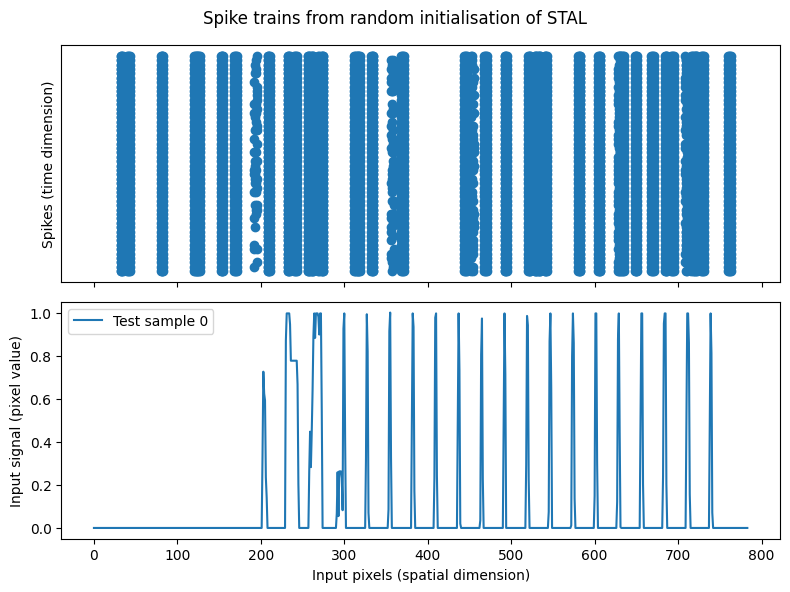

Default Loss initialized.
Epoch 1 - Train Loss: 2533.378
	- Validation Loss: 1534.214
Epoch 2 - Train Loss: 1454.369
	- Validation Loss: 1361.568
Epoch 3 - Train Loss: 1190.642
	- Validation Loss: 959.888
Epoch 4 - Train Loss: 876.161
	- Validation Loss: 797.401
Epoch 5 - Train Loss: 770.931
	- Validation Loss: 752.755
Epoch 6 - Train Loss: 718.823
	- Validation Loss: 708.938
Epoch 7 - Train Loss: 679.396
	- Validation Loss: 689.067
Epoch 8 - Train Loss: 654.262
	- Validation Loss: 640.372
Epoch 9 - Train Loss: 630.896
	- Validation Loss: 616.418
Epoch 10 - Train Loss: 634.119
	- Validation Loss: 600.957
Epoch 11 - Train Loss: 602.101
	- Validation Loss: 603.986
Epoch 12 - Train Loss: 595.722
	- Validation Loss: 575.364
Epoch 13 - Train Loss: 599.955
	- Validation Loss: 664.095
Epoch 14 - Train Loss: 607.732
	- Validation Loss: 587.776
Epoch 15 - Train Loss: 582.385
	- Validation Loss: 569.562
Epoch 16 - Train Loss: 562.722
	- Validation Loss: 572.944
Epoch 17 - Train Loss: 575.369
	- 

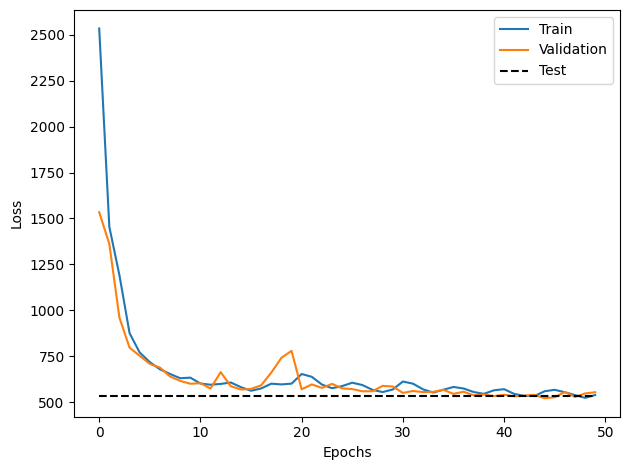

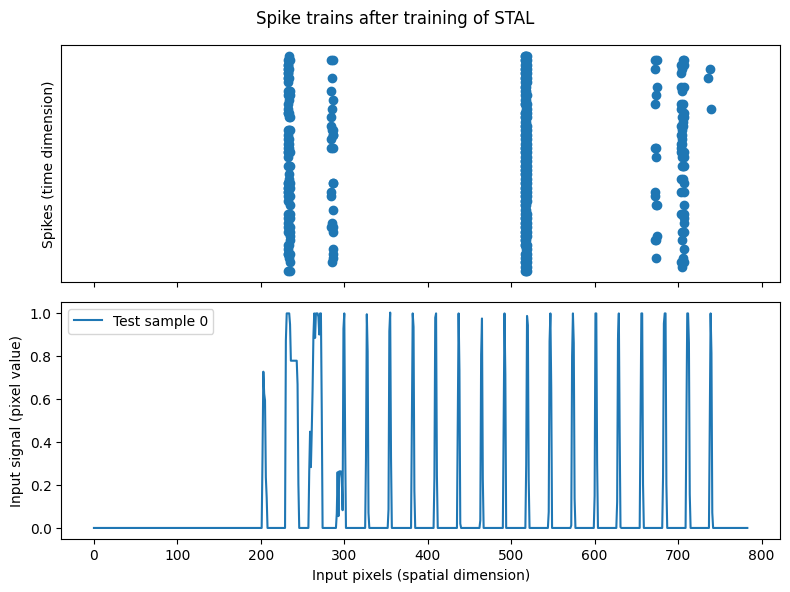

In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import time

from mnist.load_mnist import load_mnist
from STAL.STAL import SpikeThresholdAdaptiveLearning
# from STAL_loss.loss_low_sp import DefaultLoss
from STAL_loss.default_loss import DefaultLoss

device = torch.device("mps")

train_X, train_y, test_X, test_y = load_mnist()

print(train_X[0].shape, train_y[0])

omega = train_X[0].size(0)
psi = 50
c = 1
l1_sz = omega // 2 # 392
l2_sz = omega // 4 # 196
drop_p = 0.5

STAL = SpikeThresholdAdaptiveLearning(omega, psi, c, l1_sz, l2_sz, drop_p)
STAL.print_learnable_params()

batch_size = 10000
x = test_X[:batch_size]

h, Z1, Z2 = STAL(x)

theta = 0.99
spiketrain = (h > theta).float()
# [batch_size, (window_size * n_channels) * psi]

# Since we have 1 channel, let's squeeze it
B = spiketrain.reshape(batch_size, omega, c, psi).squeeze(2)

b = B[0]
pixels, spikes = np.where(b == 1)

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].scatter(pixels, (spikes/psi))
axs[0].set_ylabel("Spikes (time dimension)")
axs[0].set_yticks([])

axs[1].plot(x[0], label="Test sample 0")
axs[1].set_xlabel("Input pixels (spatial dimension)")
axs[1].set_ylabel("Input signal (pixel value)")
axs[1].legend()

plt.suptitle("Spike trains from random initialisation of STAL")
plt.tight_layout()
# plt.savefig("img/random_init_example_mnist.png")
plt.show()

# Loss and Optimizer
default_loss = DefaultLoss()
optimizer = torch.optim.AdamW(STAL.parameters(), lr=0.001)

# Train/Validation
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.2, random_state=42)
n_epochs = 50
train_X = train_X[:batch_size*10]
val_X = val_X[:batch_size*10]
train_y = train_y[:batch_size*10]
val_y = val_y[:batch_size*10]

STAL.to(device)

start = time.time()

train_loss = []
train_spiketrains = []
val_loss = []
val_spiketrains = []
for epoch in range(n_epochs):
    e = []
    for i in range(0, len(train_X), batch_size):
        x_train = train_X[i:i+batch_size].to(device)
        optimizer.zero_grad()
        h, Z1, Z2 = STAL(x_train)
        if epoch == n_epochs - 1:
            spiketrain = (h > theta).float()
            train_spiketrains = np.append(train_spiketrains, spiketrain.detach().cpu().numpy())
        loss = default_loss(h, x_train, Z1, Z2)
        loss.backward()
        optimizer.step()
        e.append(loss.item())
    train_loss.append(np.mean(e))
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss[-1]:.3f}")
    
    e = []
    with torch.no_grad():
        for i in range(0, len(val_X), batch_size):
            x_val = val_X[i:i+batch_size].to(device)
            h, Z1, Z2 = STAL(x_val)
            if epoch == n_epochs - 1:
                spiketrain = (h > theta).float()
                val_spiketrains = np.append(val_spiketrains, spiketrain.detach().cpu().numpy())
            loss = default_loss(h, x_val, Z1, Z2)
            e.append(loss.item())
    val_loss.append(np.mean(e))
    print(f"\t- Validation Loss: {val_loss[-1]:.3f}")

# Test
test_loss = []
test_spiketrains = []
for i in range(0, len(test_X), batch_size):
    x_test = test_X[:batch_size].to(device)
    h, Z1, Z2 = STAL(x_test)
    spiketrain = (h > theta).float()
    test_spiketrains = np.append(test_spiketrains, spiketrain.detach().cpu().numpy())
    loss = default_loss(h, x_test, Z1, Z2)
    test_loss.append(loss.item())

print("---")
print(f"Test Loss: {np.mean(test_loss):.3f}")
print("---")

end = time.time()
print(f"Training took {end-start:.2f}s")

def plot_loss(train_loss, val_loss, test_loss):
    plt.plot(train_loss, label="Train")
    plt.plot(val_loss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.hlines(np.mean(test_loss), 0, len(train_loss) - 1, colors='black', linestyles='dashed', label="Test")
    plt.legend()
    plt.tight_layout()
    # plt.savefig("img/loss_curves_STAL_mnist")
    plt.show()

plot_loss(train_loss, val_loss, test_loss)

# Inspect the spike train after training
STAL.cpu()
STAL.eval()

B_STAL_tr = train_spiketrains.reshape(-1, omega, c, psi).squeeze(2)
B_STAL_val = val_spiketrains.reshape(-1, omega, c, psi).squeeze(2)
B_STAL_ts = test_spiketrains.reshape(-1, omega, c, psi).squeeze(2)
b = B_STAL_ts[0]
pixels, spikes = np.where(b == 1)

fig, axs = plt.subplots(2, 1, figsize=(8, 6), sharex=True)
axs[0].scatter(pixels, (spikes/psi))
axs[0].set_ylabel("Spikes (time dimension)")
axs[0].set_yticks([])

axs[1].plot(x[0], label="Test sample 0")
axs[1].set_xlabel("Input pixels (spatial dimension)")
axs[1].set_ylabel("Input signal (pixel value)")
axs[1].legend()

plt.suptitle("Spike trains after training of STAL")
plt.tight_layout()
# plt.savefig("img/post_training_example_mnist_low_sp.png")
plt.show()



## 2. Inspecting the encoded spike trains

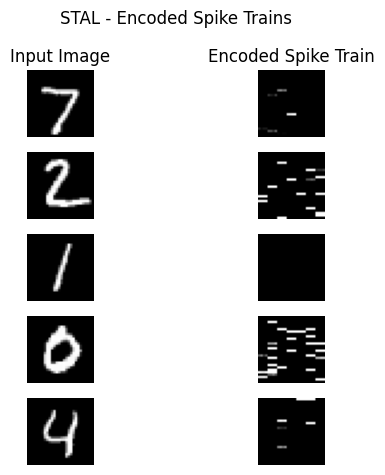

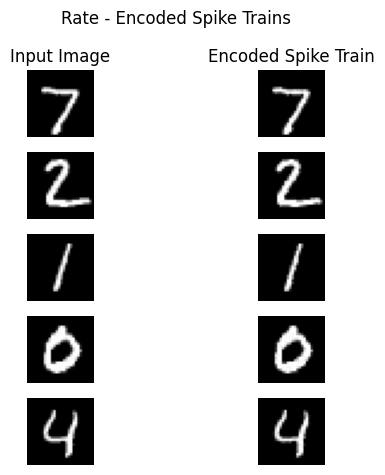

In [9]:
import snntorch as snn
from snntorch import spikegen

def plot_images(X, B, idx, title):
    fig, axs = plt.subplots(len(idx), 2)
    if len(idx) == 1:
        axs = [axs]
    
    axs[0, 0].set_title("Input Image")
    axs[0, 1].set_title("Encoded Spike Train")
    for i in idx:
        x = X[i].numpy()
        b = B[i]
        b_gray = b.mean(axis=1)
        
        axs[i, 0].imshow(x.reshape(28, 28), cmap='gray')

        axs[i, 1].imshow(b_gray.reshape(28, 28), cmap='gray')

    # Remove border
    for ax in axs.flatten():
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_xticks([])
    plt.suptitle(f"{title} - Encoded Spike Trains")
    plt.tight_layout()

plot_images(test_X, B_STAL_ts, np.arange(5), "STAL")

# Swap indices to match B_STAL's shape
B_rate_tr = spikegen.rate(train_X, psi).permute(1, 2, 0)
B_rate_val = spikegen.rate(val_X, psi).permute(1, 2, 0)
B_rate_ts = spikegen.rate(test_X, psi).permute(1, 2, 0)
plot_images(test_X, B_rate_ts, np.arange(5), "Rate")

## 3. Training simple SNN

a. Train the SNN on rate-coded spike trains \
b. Train it on the STAL spike trains \
c. Compare the performances.

In [10]:
class MNIST_SNN(torch.nn.Module):
    def __init__(self, psi):
        super(MNIST_SNN, self).__init__()
        self.lif = snn.LeakyParallel(input_size=28*28*psi, hidden_size=10)
        
    def forward(self, x):
        x = x.reshape(x.size(0), -1)
        spk = self.lif(x)
        return spk
    
snn_model = MNIST_SNN(psi)
snn_model

MNIST_SNN(
  (lif): LeakyParallel(
    (rnn): RNN(39200, 10)
  )
)

#### a. Train on rate

Epoch 1 - Train Loss: 2.283
	- Validation Loss: 2.083
Epoch 2 - Train Loss: 1.998
	- Validation Loss: 1.906
Epoch 3 - Train Loss: 1.862
	- Validation Loss: 1.825
Epoch 4 - Train Loss: 1.792
	- Validation Loss: 1.764
Epoch 5 - Train Loss: 1.741
	- Validation Loss: 1.717
Epoch 6 - Train Loss: 1.703
	- Validation Loss: 1.684
Epoch 7 - Train Loss: 1.677
	- Validation Loss: 1.662
Epoch 8 - Train Loss: 1.658
	- Validation Loss: 1.647
Epoch 9 - Train Loss: 1.644
	- Validation Loss: 1.636
Epoch 10 - Train Loss: 1.634
	- Validation Loss: 1.628
Epoch 11 - Train Loss: 1.626
	- Validation Loss: 1.622
Epoch 12 - Train Loss: 1.619
	- Validation Loss: 1.618
Epoch 13 - Train Loss: 1.614
	- Validation Loss: 1.614
Epoch 14 - Train Loss: 1.610
	- Validation Loss: 1.610
Epoch 15 - Train Loss: 1.605
	- Validation Loss: 1.607
Epoch 16 - Train Loss: 1.602
	- Validation Loss: 1.604
Epoch 17 - Train Loss: 1.599
	- Validation Loss: 1.604
Epoch 18 - Train Loss: 1.596
	- Validation Loss: 1.601
Epoch 19 - Train Lo

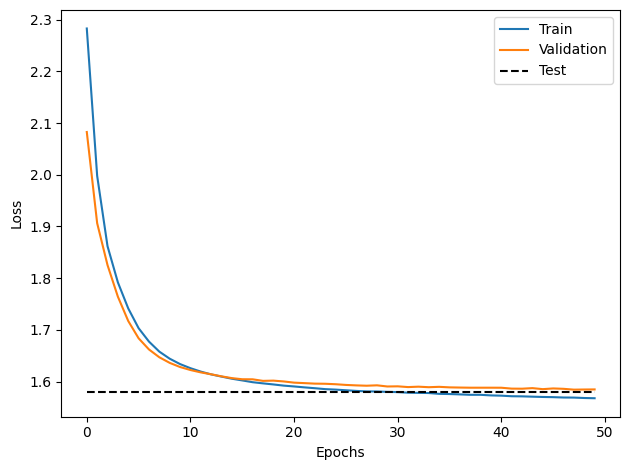

Test Loss: 1.580
Rate: 83.67% accuracy on test set
Training took 1521.21s


In [12]:
cls_epochs = 20
batch_size = 10000

snn_model = MNIST_SNN(psi)
snn_model.to(device)
optimizer = torch.optim.AdamW(snn_model.parameters(), lr=0.001)

# Train (rate)
train_loss = []
val_loss = []

start = time.time()
for epoch in range(cls_epochs):
    e = []
    for i in range(0, len(B_rate_tr), batch_size):
        x_train = B_rate_tr[i:i+batch_size].float().to(device)
        y_train = train_y[i:i+batch_size].long().to(device)
        optimizer.zero_grad()

        spk = snn_model(x_train)
        loss = torch.nn.functional.cross_entropy(spk, y_train)
        loss.backward()
        optimizer.step()
        e.append(loss.item())
    train_loss.append(np.mean(e))
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss[-1]:.3f}")
    
    # Validation
    e = []
    with torch.no_grad():
        for i in range(0, len(B_rate_val), batch_size):
            x_val = B_rate_val[i:i+batch_size].float().to(device)
            y_val = val_y[i:i+batch_size].long().to(device)
            spk = snn_model(x_val)
            loss = torch.nn.functional.cross_entropy(spk, y_val)
            e.append(loss.item())
    val_loss.append(np.mean(e))
    print(f"\t- Validation Loss: {val_loss[-1]:.3f}")
    
# Test
e = []
test_loss = []
test_acc_rate = 0
with torch.no_grad():
    for i in range(0, len(B_rate_ts), batch_size):
        x_test = B_rate_ts[i:i+batch_size].float().to(device)
        y_test = test_y[i:i+batch_size].long().to(device)
        spk = snn_model(x_test)
        loss = torch.nn.functional.cross_entropy(spk, y_test)
        test_loss.append(loss.item())
        pred = spk.argmax(dim=1)
        test_acc_rate += (pred == y_test).float().mean().item()
        e.append(loss.item())

plot_loss(train_loss, val_loss, test_loss)

print(f"Test Loss: {np.mean(e):.3f}")
print(f"Rate: {test_acc_rate*100:.2f}% accuracy on test set")

end = time.time()
print(f"Training took {end-start:.2f}s")

#### b. Train on STAL

Epoch 1 - Train Loss: 2.316
	- Validation Loss: 2.241
Epoch 2 - Train Loss: 2.194
	- Validation Loss: 2.149
Epoch 3 - Train Loss: 2.118
	- Validation Loss: 2.095
Epoch 4 - Train Loss: 2.067
	- Validation Loss: 2.056
Epoch 5 - Train Loss: 2.035
	- Validation Loss: 2.031
Epoch 6 - Train Loss: 2.011
	- Validation Loss: 2.011
Epoch 7 - Train Loss: 1.993
	- Validation Loss: 2.001
Epoch 8 - Train Loss: 1.979
	- Validation Loss: 1.992
Epoch 9 - Train Loss: 1.968
	- Validation Loss: 1.986
Epoch 10 - Train Loss: 1.960
	- Validation Loss: 1.982
Epoch 11 - Train Loss: 1.952
	- Validation Loss: 1.979
Epoch 12 - Train Loss: 1.946
	- Validation Loss: 1.975
Epoch 13 - Train Loss: 1.940
	- Validation Loss: 1.973
Epoch 14 - Train Loss: 1.934
	- Validation Loss: 1.973
Epoch 15 - Train Loss: 1.930
	- Validation Loss: 1.972
Epoch 16 - Train Loss: 1.927
	- Validation Loss: 1.971
Epoch 17 - Train Loss: 1.923
	- Validation Loss: 1.971
Epoch 18 - Train Loss: 1.920
	- Validation Loss: 1.971
Epoch 19 - Train Lo

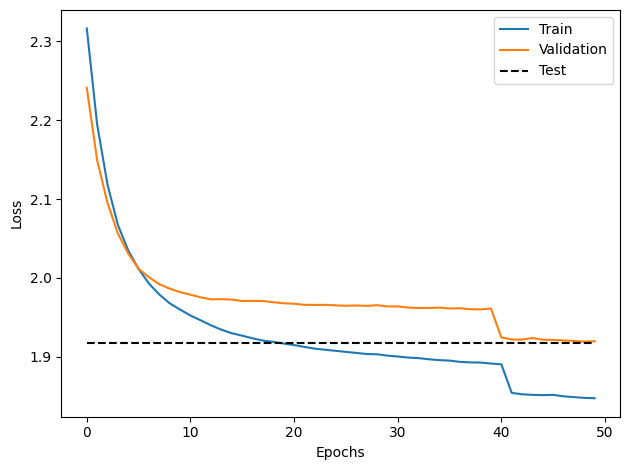

Test Loss: 1.917
STAL: 40.67% accuracy on test set
Training took 1533.73s


In [13]:
B_STAL_tr = torch.tensor(B_STAL_tr)
B_STAL_val = torch.tensor(B_STAL_val)
B_STAL_ts = torch.tensor(B_STAL_ts)

snn_model = MNIST_SNN(psi)
snn_model.to(device)
optimizer = torch.optim.AdamW(snn_model.parameters(), lr=0.001)

# Train (STAL)
train_loss = []
val_loss = []

start = time.time()
for epoch in range(cls_epochs):
    e = []
    for i in range(0, len(B_STAL_tr), batch_size):
        x_train = B_STAL_tr[i:i+batch_size].float().to(device)
        y_train = train_y[i:i+batch_size].long().to(device)
        optimizer.zero_grad()

        spk = snn_model(x_train)
        loss = torch.nn.functional.cross_entropy(spk, y_train)
        loss.backward()
        optimizer.step()
        e.append(loss.item())
    train_loss.append(np.mean(e))
    print(f"Epoch {epoch + 1} - Train Loss: {train_loss[-1]:.3f}")
    
    # Validation
    e = []
    with torch.no_grad():
        for i in range(0, len(B_STAL_val), batch_size):
            x_val = B_STAL_val[i:i+batch_size].float().to(device)
            y_val = val_y[i:i+batch_size].long().to(device)
            spk = snn_model(x_val)
            loss = torch.nn.functional.cross_entropy(spk, y_val)
            e.append(loss.item())
    val_loss.append(np.mean(e))
    print(f"\t- Validation Loss: {val_loss[-1]:.3f}")
    
# Test
e = []
test_loss = []
test_acc_stal = 0
with torch.no_grad():
    for i in range(0, len(B_STAL_ts), batch_size):
        x_test = B_STAL_ts[i:i+batch_size].float().to(device)
        y_test = test_y[i:i+batch_size].long().to(device)
        spk = snn_model(x_test)
        loss = torch.nn.functional.cross_entropy(spk, y_test)
        test_loss.append(loss.item())
        pred = spk.argmax(dim=1)
        test_acc_stal += (pred == y_test).float().mean().item()
        e.append(loss.item())

plot_loss(train_loss, val_loss, test_loss)

print(f"Test Loss: {np.mean(e):.3f}")
print(f"STAL: {test_acc_stal*100:.2f}% accuracy on test set")

end = time.time()
print(f"Training took {end-start:.2f}s")

#### c. Compare Rate v. STAL

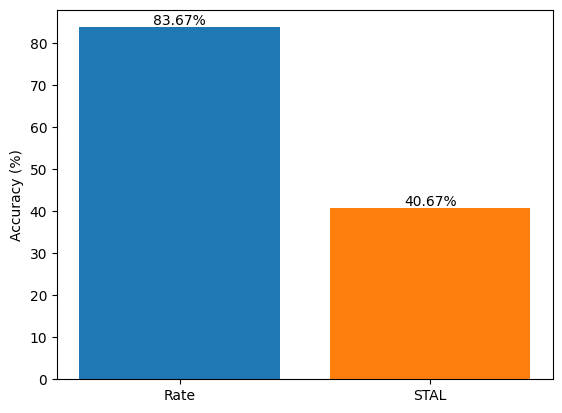

In [21]:
c = plt.cm.tab10.colors
plt.bar(["Rate", "STAL"], [test_acc_rate*100, test_acc_stal*100], color=c)
plt.text(0, test_acc_rate*100, f"{test_acc_rate*100:.2f}%", ha='center', va='bottom')
plt.text(1, test_acc_stal*100, f"{test_acc_stal*100:.2f}%", ha='center', va='bottom')
plt.ylabel("Accuracy (%)")
plt.show()